In [1]:
# import python modules
from collections import Counter
import pickle

# import general data science modules 
from scipy import interpolate
import numpy as np
import pandas as pd

# import plot modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import sklearn modules
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# import project specific modules
import h5py

## Read raw h5 data

In [2]:
# Read raw data into raw_energies, raw_fluos, raw_trans and raw_refs.
fh5 = h5py.File("Co_ISS_data.h5", 'r')
key_list = list(fh5.keys())

keys = []
fnames = []
raw_energies = []

keys = {k:k for k in list(fh5.keys())}
fnames = {k:str(fh5[k]['filename'][...]) for k in key_list}
raw_energies = {k:fh5[k]['energy'][...] for k in key_list}
raw_fluos = {k:fh5[k]['fluo'][...] for k in key_list}
raw_trans = {k:fh5[k]['trans'][...] for k in key_list}

## Read normalized data and predictions from NN

In [3]:
# Read reduced & normalized data between for range 7600~8000
norm_left = 7600
norm_right = 8000

# Read normalized data 
with open("e{}-{}_grid400_spec_norm.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    spec_norm = pickle.load(f)

red_norm = spec_norm['spec']
feature_grid = spec_norm['feature_grid']
keys = spec_norm['key'] * 2
files = spec_norm['file'] * 2
types = ['trans']*len(spec_norm['key']) + ['fluo']*len(spec_norm['key'])

# read predicted labels from Neural networks
with open("e{}-{}_grid400_prediction.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    result = pickle.load(f)
    
labels = result['label']
sets = result['set']


## Construct a DataFrame

Construct a DataFrame with columns: 
1. key: keys in h5 data
2. type: whether it is a transmision scan or a fluorescence scan
3. label: a float between 0 and 1 indicating the probility of being a good data
4. set: "train" and "test" categories with "train" being data identified by clustering and "test" being unlabeled data in the clustering step.
5. 7600.0 ... 7999.0: energy columns for spec data, toatling 400 grids with neighboring grids 1ev apart.

In [4]:
# info part containing 'key', 'label' and 'set'
info = pd.DataFrame(
     {
         'key': np.array(keys, dtype=str),
         'type': pd.Categorical(types),
         'label': np.array(labels, dtype=float),
         'set': pd.Categorical(sets)
     }
)

# spec part containing energy grids
spec = pd.DataFrame(red_norm, columns=feature_grid)

# concatenate two parts
data = pd.concat([info, spec], axis=1)

In [5]:
data.head(10)

,key,type,label,set,7600.0,7601.0,7602.0,7603.0,7604.0,7605.0,...,7990.0,7991.0,7992.0,7993.0,7994.0,7995.0,7996.0,7997.0,7998.0,7999.0
0,0,trans,0.000679,test,0.025072,0.032305,0.039537,0.046770,0.005118,0.012350,...,-0.434847,-0.427614,-0.420381,-0.419244,-0.412012,-0.417600,-0.410368,-0.403135,-0.409281,-0.402049
1,1,trans,0.000000,train,-0.297937,-0.308026,-0.318115,-0.328204,-0.200631,-0.210720,...,-3.326382,-3.336471,-3.346559,-2.990989,-3.001078,-2.715217,-2.725306,-2.735395,-4.157683,-4.167772
2,10,trans,0.000001,test,0.423077,0.446151,0.469225,0.492300,0.299834,0.322909,...,4.848739,4.871814,4.894888,4.840391,4.863465,4.841595,4.864669,4.887743,4.919263,4.942337
3,100,trans,0.000162,test,0.110538,0.132685,0.154832,0.176979,0.056635,0.078783,...,4.426163,4.448311,4.470458,4.451922,4.474069,4.444544,4.466691,4.488838,4.399173,4.421321
4,10000,trans,0.000395,test,-0.025089,-0.014059,-0.003028,0.008003,0.019033,-0.039141,...,0.823520,0.823413,0.834444,0.845475,0.839041,0.850072,0.861102,0.846853,0.857884,0.835678
5,10001,trans,0.000188,test,-0.031001,-0.020677,-0.010354,-0.000031,0.010292,-0.055517,...,0.577464,0.594045,0.604369,0.614692,0.593216,0.603539,0.613862,0.588455,0.598779,0.581814
6,10002,trans,0.000003,test,0.019321,-0.044193,-0.033508,-0.022823,-0.012138,-0.001453,...,0.662610,0.651861,0.662546,0.673231,0.656810,0.667495,0.678180,0.688190,0.698874,0.674670
7,10003,trans,0.000013,test,0.031171,-0.030462,-0.019479,-0.008496,0.002487,0.013469,...,0.778003,0.789415,0.800398,0.811381,0.803629,0.814612,0.825594,0.822624,0.833607,0.813680
8,10004,trans,0.001775,test,-0.031612,-0.021128,-0.010644,-0.000160,0.010324,-0.069905,...,0.648396,0.629148,0.639632,0.650116,0.625303,0.635787,0.646271,0.637384,0.647868,0.627593
9,10005,trans,0.373718,test,-0.026676,-0.016465,-0.006255,0.003956,0.014167,-0.044062,...,0.510476,0.496762,0.506973,0.517184,0.516430,0.526641,0.536852,0.544381,0.554592,0.545177


In [9]:
data[data['set']=='train'].shape

(7292, 404)

### Display good data in training set

In [97]:
select_set = data['set']=='test' # select test set
select_quality = data['label']==1.0 # select label==1.0

select_keys = data[select_set & select_quality]['key'] # keys of selected spectra
select_type = data.iloc[select_keys.index]['type'] # type of selected spectra
select_spec = data.loc[select_keys.index,feature_grid] # selected spectra

data.iloc[select_keys.index].head(10)

,key,type,label,set,7600.0,7601.0,7602.0,7603.0,7604.0,7605.0,...,7990.0,7991.0,7992.0,7993.0,7994.0,7995.0,7996.0,7997.0,7998.0,7999.0
96,10094,trans,1.0,test,0.028551,-0.001305,0.004713,0.010731,0.016749,0.022766,...,2.952714,2.940889,2.946907,2.952925,2.940252,2.946270,2.952288,2.943516,2.949534,2.937179
99,10097,trans,1.0,test,0.022257,-0.002904,0.003224,0.009351,0.015479,0.021607,...,2.979277,2.966148,2.972276,2.978404,2.965926,2.972054,2.978181,2.964462,2.970590,2.958019
100,10098,trans,1.0,test,0.026304,-0.001237,0.004853,0.010943,0.017032,0.023122,...,2.968707,2.957679,2.963769,2.969859,2.958142,2.964231,2.970321,2.958153,2.964243,2.953662
107,10104,trans,1.0,test,-0.002769,0.003452,0.009673,0.015894,0.022115,-0.006492,...,2.985168,2.975180,2.981401,2.987622,2.975631,2.981852,2.988072,2.973930,2.980151,2.966204
108,10105,trans,1.0,test,0.003692,0.009878,0.016064,0.022250,0.028437,-0.000660,...,2.969430,2.954616,2.960802,2.966988,2.956076,2.962262,2.968448,2.953963,2.960149,2.947142
117,10114,trans,1.0,test,0.022530,-0.000862,0.004452,0.009767,0.015081,0.020396,...,2.921742,2.912394,2.917709,2.923023,2.916777,2.922091,2.927406,2.909938,2.915252,2.907301
118,10115,trans,1.0,test,0.020857,-0.003096,0.002278,0.007651,0.013025,0.018399,...,2.943748,2.935228,2.940602,2.945976,2.931688,2.937062,2.942436,2.933479,2.938853,2.928526
119,10116,trans,1.0,test,0.020524,0.000447,0.005821,0.011196,0.016571,0.021945,...,2.932464,2.923495,2.928870,2.934244,2.926301,2.931675,2.937050,2.928696,2.934071,2.924534
120,10117,trans,1.0,test,0.023896,-0.001086,0.004297,0.009680,0.015063,0.020446,...,2.937890,2.931915,2.937298,2.942681,2.933939,2.939322,2.944705,2.931421,2.936804,2.927007
121,10118,trans,1.0,test,0.019688,-0.003401,0.001941,0.007283,0.012625,0.017967,...,2.922045,2.907216,2.912558,2.917900,2.910060,2.915402,2.920744,2.929649,2.934991,2.913910


### Randomly pick 10 good test data and plot them out along raw data
1. The legend is of form "key: type, filename"
2. Repetitive executions of the cell generate different random selections

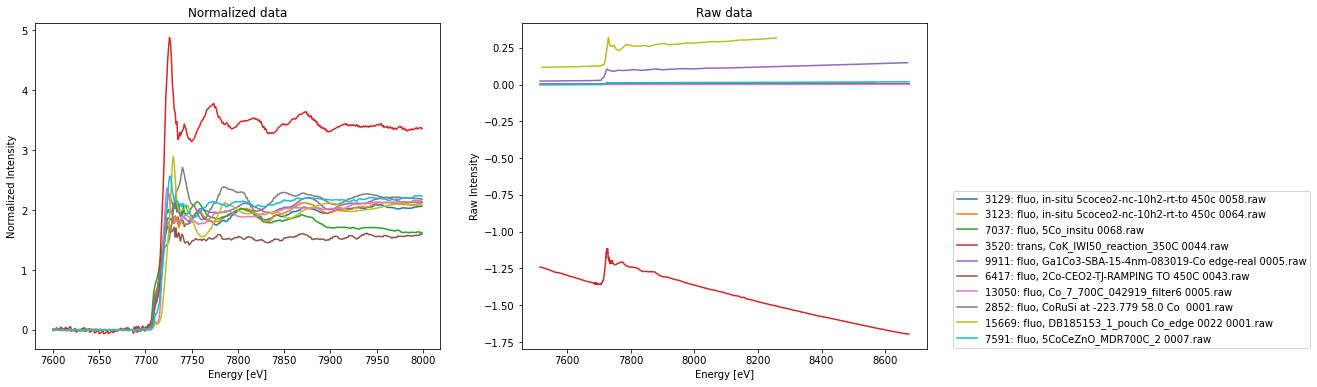

In [143]:
keys_test_good = select_keys.to_numpy(dtype=str)
type_test_good = select_type.to_numpy(dtype=str)
spec_test_good = select_spec.to_numpy(dtype=float)

rand_index_list = np.random.randint(len(keys_test_good),size=10)
rand_key_list = keys_test_good[rand_index_100]
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[0].set_ylabel('Normalized Intensity')
axs[0].set_xlabel('Energy [eV]')
axs[0].set_title('Normalized data')
axs[1].set_ylabel('Raw Intensity')
axs[1].set_xlabel('Energy [eV]')
axs[1].set_title('Raw data')
for i in rand_index_list:
    axs[0].plot(feature_grid, spec_test_good[i], label=keys_test_good[i])
for i in rand_index_list:
    k = keys_test_good[i]
    t = type_test_good[i]
    axs[1].plot(fh5[k]['energy'], fh5[k][t], label="{:s}: {:s}, {:s}".format(k, t, fnames[k]))
plt.legend(bbox_to_anchor=(1.05,0.5))
plt.show()    